# Data cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load csv
jfk = pd.read_csv('/content/JFK_flight_data.csv')

# Drop null values
jfk = jfk.dropna()

# One-hot encoding for categorical variables
one_hot = pd.get_dummies(jfk['OP_UNIQUE_CARRIER'])
jfk = jfk.drop('OP_UNIQUE_CARRIER',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['DEST'])
jfk = jfk.drop('DEST',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Wind'])
jfk = jfk.drop('Wind',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Condition'])
jfk = jfk.drop('Condition',axis = 1)
jfk = jfk.join(one_hot)

jfk.loc[jfk['MONTH']==1, 'MONTH'] = 'Jan'
jfk.loc[jfk['MONTH']==11, 'MONTH'] = 'Nov'
jfk.loc[jfk['MONTH']==12, 'MONTH'] = 'Dec'
one_hot = pd.get_dummies(jfk['MONTH'])
jfk = jfk.drop('MONTH', axis = 1)
jfk = jfk.join(one_hot)

# Drop unneeded columns
jfk = jfk.drop(columns = ['TAIL_NUM','DEP_TIME_M'])

# Change type of Dew Point column to int
jfk['Dew Point'] = jfk['Dew Point'].astype(int)
     
# Turn target column into a categorical variable based on whether the departure
#     delay is 15 minutes or more.

jfk['DEP_DELAY_CAT'] = jfk['DEP_DELAY'].apply(lambda x: 1 if x > 15 else 0)

# Drop original departure delay column

jfk = jfk.drop('DEP_DELAY', axis = 1)

# Train-test-validation split

In [3]:
# Train test validation split 

# Train-test split
from sklearn.model_selection import train_test_split

X,y = jfk.loc[:, jfk.columns != 'DEP_DELAY_CAT'], jfk.loc[:, 'DEP_DELAY_CAT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=604)

# Train-validation split

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 604)

# XGBoost classifier

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Tune hyperparameters using GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    cv = 5,
    n_jobs = 5,
    verbose = True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10, 2),
                         'n_estimators': [100, 200, 500]},
             scoring='f1', verbose=True)

In [ ]:
#Hyperparameters for the best model above

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}

In [6]:
# Validation set scores for model above

xgb = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.1,
    max_depth=8,
    n_estimators = 500,
    seed=42
)
model = xgb.fit(X_train_train,y_train_train)
pred = xgb.predict(X_val)

print('the accuracy score is', accuracy_score(y_val, pred))
print('the recall score is',recall_score(y_val, pred))
print('the precision is', precision_score(y_val, pred)) 
print('the f1 score is', f1_score(y_val, pred))

the accuracy score is 0.9180221210149642
the recall score is 0.4503311258278146
the precision is 0.8553459119496856
the f1 score is 0.5900216919739696


In [7]:
# Fine-tune hyperparameters

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [7,8,9],
    'n_estimators': [200, 500],
    'learning_rate': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    cv = 5,
    n_jobs = 5,
    verbose = True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [7, 8, 9], 'n_estimators': [200, 500]},
             scoring='f1', verbose=True)

In [8]:
# Best hyperparameters

grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}

In [5]:
# Validation set scores for model above

xgb = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.3,
    max_depth=7,
    n_estimators = 500
)
model = xgb.fit(X_train_train,y_train_train)
pred = xgb.predict(X_val)

print('the accuracy score is', accuracy_score(y_val, pred))
print('the recall score is',recall_score(y_val, pred))
print('the precision is', precision_score(y_val, pred)) 
print('the f1 score is', f1_score(y_val, pred))

the accuracy score is 0.9186727391021471
the recall score is 0.4900662251655629
the precision is 0.8154269972451791
the f1 score is 0.6122026887280247


In [6]:
# Fine-tune hyperparameters

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [7],
    'n_estimators': [500],
    'learning_rate': [0.3,0.4,0.5]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    cv = 5,
    n_jobs = 5,
    verbose = True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.3, 0.4, 0.5], 'max_depth': [7],
                         'n_estimators': [500]},
             scoring='f1', verbose=True)

In [7]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}

In [8]:
# Fine-tune hyperparameters

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [7],
    'n_estimators': [500],
    'learning_rate': [0.25,0.3,0.35]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    cv = 5,
    n_jobs = 5,
    verbose = True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.25, 0.3, 0.35], 'max_depth': [7],
                         'n_estimators': [500]},
             scoring='f1', verbose=True)

In [9]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}

In [14]:
# This is again the best set of hyperparameters from the tuning
# We repeat the scores here

# Validation set error for model above

xgb = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.3,
    max_depth=7,
    n_estimators = 500
)
model = xgb.fit(X_train_train,y_train_train)
pred = xgb.predict(X_val)

print('the accuracy score is', accuracy_score(y_val, pred))
print('the recall score is',recall_score(y_val, pred))
print('the precision is', precision_score(y_val, pred)) 
print('the f1 score is', f1_score(y_val, pred))

the accuracy score is 0.9186727391021471
the recall score is 0.4900662251655629
the precision is 0.8154269972451791
the f1 score is 0.6122026887280247


Normalized Confusion Matrix for XGBoost Classifier




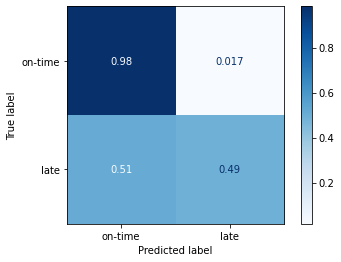

In [15]:
# Normalized confusion matrix for the model above

from sklearn.metrics import ConfusionMatrixDisplay

print('Normalized Confusion Matrix for XGBoost Classifier')
print('\n')

ConfusionMatrixDisplay.from_predictions(y_val, pred, 
                                        display_labels=['on-time','late'], 
                                        cmap=plt.cm.Blues,
                                        normalize = 'true')

In [12]:
# Get scores on the test set

xgb = XGBClassifier(
    objective= 'binary:logistic',
    learning_rate=0.3,
    max_depth=7,
    n_estimators = 500
)
model = xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)

print('the accuracy score is', accuracy_score(y_test, pred))
print('the recall score is',recall_score(y_test, pred))
print('the precision is', precision_score(y_test, pred)) 
print('the f1 score is', f1_score(y_test, pred))

the accuracy score is 0.9089174184594032
the recall score is 0.4827175208581645
the precision is 0.8165322580645161
the f1 score is 0.6067415730337078


Normalized Confusion Matrix for XGBoost Classifier




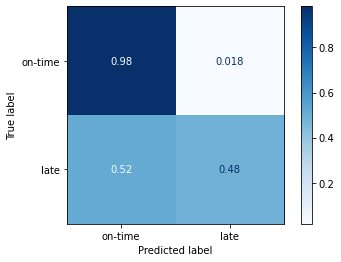

In [13]:
# Normalized confusion matrix for the model above on the test set

from sklearn.metrics import ConfusionMatrixDisplay

print('Normalized Confusion Matrix for XGBoost Classifier')
print('\n')

ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        display_labels=['on-time','late'], 
                                        cmap=plt.cm.Blues,
                                        normalize = 'true')